In [ ]:
#pip install similaritymeasures

In [ ]:
#pip install tslearn

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from termcolor import colored
import csv
#import tslearn
#from tslearn.metrics import dtw

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Read data (car-bus)

In [ ]:
def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(np.array(item))
    return np.array(data)

data1 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_tracks.csv')[1:,:-1]
data2 = read_file('/content/gdrive/My Drive/Colab Notebooks/go_track_trackspoints.csv')[1:,1:4]

float1 = np.vectorize(float)
int1 = np.vectorize(int)
track_id = int1(data1[:,0])
labels = np.where(int1(data1[:,-1]) < 1.5, int1(data1[:,-1]), -1) 
traj = float1(data2)

sum(labels==1), sum(labels==-1)

(87, 76)

In [ ]:
trajec = [0] * 163

for i in range(163):
    trajec[i] = []
    I = np.where(traj[:,2] == track_id[i])
    trajec[i] = np.array([labels[i], traj[I]], dtype = 'object')

trajec = np.array(trajec)

trajectory = [0] * 163
trajectory_label_id = [0] * 163

for i in range(163):
    trajectory[i] = trajec[i][1][:,:2]
    trajectory_label_id[i] = np.array([trajec[i][1][:,:2], trajec[i][0], 
                                       trajec[i][1][:,2][0]], dtype = 'object')
    
trajectory_label_id = np.array(trajectory_label_id, dtype = 'object')
trajectory = np.array(trajectory, dtype = 'object')

min_length = 10
max_length = 1000
l = 0
index = [] 
for i in range(163):
    if len(trajectory[i]) < min_length or len(trajectory[i]) > max_length:
        l = l + 1
    else:
        index.append(i)
        
print(l, 163-l)

(40, 123)

In [ ]:
trajectories = [0] * (163-l)
trajectories_label_id = [0] * (163-l)

j = 0
for i in range(163):
    if len(trajectory[i]) >= min_length and len(trajectory[i]) <= max_length:
        trajectories[j] = np.array(trajectory[i])
        trajectories_label_id[j] = trajectory_label_id[i]
        j = j + 1

trajectories_label_id = np.array(trajectories_label_id, dtype = 'object')
trajectories = np.array(trajectories, dtype = 'object')

cars = trajectories_label_id[np.where(trajectories_label_id[:,1] == 1)][:,:2][:,0]
buses = trajectories_label_id[np.where(trajectories_label_id[:,1] == -1)][:,:2][:,0]

cars_copy = cars.copy()
buses_copy = buses.copy()
print(len(cars), len(buses))

(78, 45)

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[1:]
    p1 = traj[:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

In [ ]:
cars = np.array(list(map(remove_segments, cars)), dtype='object')
buses = np.array(list(map(remove_segments, buses)), dtype='object')

I = np.where(np.array([len(cars[i]) for i in range(len(cars))]) > 1)
J = np.where(np.array([len(buses[i]) for i in range(len(buses))]) > 1)

cars = cars[I]
buses = buses[J]

cars_copy = cars.copy()
buses_copy = buses.copy()
print("len(cars), len(buses)=", len(cars), len(buses))

len(cars), len(buses)= 78 45


# Removing 2 outliers and 13 duplicates

In [ ]:
a = np.arange(len(cars))
I = np.where((a != 11) & (a != 12) & (a != 28) & (a != 29))
cars1 = cars[I]
buses1 = buses[:-1]
print(len(cars1), len(buses1))

(74, 44)

In [ ]:
cars = []
buses = []

for i in range(len(cars1)):
    if i not in [6, 21, 29, 31, 33, 35, 37, 54]:
        cars.append(cars1[i])

for i in range(len(buses1)):
    if i not in [82-74, 86-74, 93-74, 96-74, 98-74]:
        buses.append(buses1[i])

cars = np.array(cars, dtype='object')
buses = np.array(buses, dtype='object')
print(len(cars), len(buses))

(66, 39)

Original car-bus


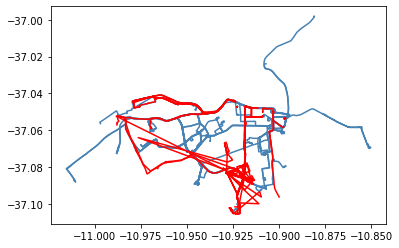

In [ ]:
a, c = np.min((np.min([np.min(cars[i], axis=0) for i in range(len(cars))], axis=0), 
       np.min([np.min(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)
  
b, d = np.max((np.max([np.max(cars[i], axis=0) for i in range(len(cars))], axis=0), 
               np.max([np.max(buses[i], axis=0) for i in range(len(buses))], axis=0)), axis=0)

for i in range(len(cars)):
    plt.plot(cars[i][:,0], cars[i][:,1], color = "steelblue");
for i in range(len(buses)):
    plt.plot(buses[i][:,0], buses[i][:,1], color = "r");

print(colored(f'Original car-bus', 'yellow'))
plt.show()

In [ ]:
data = np.concatenate((cars, buses), 0)
print(len(data))

105

# DTW distances

In [ ]:
def calculate_dists_dtw_tslearn(data1, data2, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(tslearn.metrics.dtw(data[i], data[j]))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
# Run just for once
path = '/content/gdrive/My Drive/IR Project/Car-Bus/'
#calculate_dists_dtw_tslearn(cars, buses, path=path)

In [ ]:
dists_dtw = np.array(pd.read_csv(path+'dtw-car-bus.csv', header=None))
dists_df = pd.read_csv(path+'dtw-car-bus.csv', header=None)
#dists_dtw[:5, :5]
dists_df.head()[[0,1,2,3,4,5,6,7,8,9]]

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.237153,0.044598,0.355609,0.450704,0.516058,0.366866,0.240735,0.392716,0.593286
1,0.237153,0.000000,0.234396,0.520422,0.639423,0.645120,0.526944,0.282475,0.271233,0.704242
2,0.044598,0.234396,0.000000,0.390219,0.500357,0.567860,0.402758,0.271129,0.385550,0.708856
3,0.355609,0.520422,0.390219,0.000000,0.160107,0.081285,0.203086,0.648721,0.836305,0.040976
4,0.450704,0.639423,0.500357,0.160107,0.000000,0.184160,0.197985,0.696510,0.897018,0.204119


In [ ]:
dists_dtw.shape

(105, 105)

In [ ]:
ranked_inverted_index_dtw = np.argsort(dists_dtw, 1)

In [ ]:
#np.savetxt(path+'ranked_inverted_index_dtw.csv', ranked_inverted_index_dtw, delimiter=',')

In [ ]:
ranks_dtw = np.vectorize(int)(np.array(pd.read_csv(path+'ranked_inverted_index_dtw.csv', header=None)))
ranks_dtw

array([[  0,  49,   2, ...,  44,  48,  47],
       [  1,  64,  94, ...,  74,  44,  47],
       [  2,   0,  49, ...,  74,  48,  47],
       ...,
       [102,  95,  33, ...,  48,  74,  44],
       [103,  13,   5, ...,  18,  48,  44],
       [104,   4,  70, ...,  18,  48,  44]])

# Vectorizing trajectories

## Functions

In [ ]:
n_x_grids = 50
n_y_grids = 50
path = '/content/gdrive/My Drive/IR Project/Car-Bus/'
sigma_coeff = 3
M = len(data) # data[:M]
reduction_dim = 25
option = 'binary' #'multipass'
max_limit=50

In [ ]:
def getGridsXAndY(data, n_x_grids, n_y_grids, path=None):
    '''
    path = '/content/gdrive/My Drive/IR Project/Car-Bus/'
    return: x, y-linspaces in the rectangle (x_min, y_min), (x_max, y_max)
    '''
    x_min, y_min = np.min([np.min(data[i], axis=0) for i in range(len(data))], axis=0)
    x_max, y_max = np.max([np.max(data[i], axis=0) for i in range(len(data))], axis=0)
    x_margin = 0.05 * (x_max - x_min)
    y_margin = 0.05 * (y_max - y_min)
    x = np.linspace(x_min - x_margin, x_max + x_margin, n_x_grids+1)
    y = np.linspace(y_min - y_margin, y_max + y_margin, n_y_grids+1)
    if path:
        np.savetxt(path+"x.csv", x.reshape(1, len(x)), delimiter=",")
        np.savetxt(path+"y.csv", y.reshape(1, len(y)), delimiter=",")
        np.savetxt(path+"minMaxs.csv", [x_min, y_min, x_max, y_max], delimiter="'")
    return x, y, x_min, y_min, x_max, y_max

In [ ]:
x, y, x_min, y_min, x_max, y_max = getGridsXAndY(data, n_x_grids, n_y_grids, path=path)
n_x_grids = len(x) - 1
n_y_grids = len(y) - 1

In [ ]:
def centersSimilarityMatrix(sigma_coeff=3):
    '''
    Gives the similarity matrix of centers of grids using Gauusian kernel
    '''
    tensor = np.zeros((n_x_grids, n_y_grids, 2))
    for i in range(n_x_grids):
        for j in range(n_y_grids): 
            tensor[i][j] = [(x[i]+x[i+1])/2, (y[j]+y[j+1])/2]
    tensor = tensor.reshape(-1,2)
    simMatrix = np.ones((len(tensor), len(tensor)))
    sigma = sigma_coeff * ((y_max-y_min)+(x_max-x_min))/(n_x_grids + n_y_grids)
    for i in range(len(tensor) - 1):
        simMatrix[i][i+1:] = np.exp(-np.sum((tensor[i+1:]-tensor[i])*(tensor[i+1:]-tensor[i]), 
                                             axis=1)/sigma**2)
    for i in range(len(tensor) - 1):
        simMatrix[:,i][i+1:] = simMatrix[i][i+1:]
    return simMatrix

In [ ]:
C = centersSimilarityMatrix(sigma_coeff)
C.shape

(2500, 2500)

In [ ]:
def vectorizeLineSegment(LineSegment): 
    '''
    LineSegment: of shape (2, 2); coordinates of start and end are given; [[x1, y1], [x2, y2]]
    return: a binary vector of length n_x_grids x n_y_grids, which shows if 
            LineSegment has occured in each grid or not
    '''
    array = np.zeros((n_x_grids, n_y_grids))
    p1, p2 = LineSegment
    slope = (p2-p1)[1]/((p2-p1)[0] + 1e-10)
    i1 = np.where(x - p1[0] < 0)[0][-1]
    i2 = np.where(x - p2[0] < 0)[0][-1]
    xIdxStart = min(i1, i2)
    xIdxEnd = max(i1, i2)

    if xIdxEnd != xIdxStart:
        ''' dealing with start point of lineSegment'''
        if i1 < i2:
            j_start = np.where(y - p1[1] < 0)[0][-1]
            y_val_end = slope * (x[i1+1] - p1[0]) + p1[1]
        else:
            j_start = np.where(y - p2[1] < 0)[0][-1]
            y_val_end = slope * (x[i2+1] - p1[0]) + p1[1]
        j_end = np.where(y - y_val_end < 0)[0][-1]
        array[xIdxStart][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1

        ''' dealing with end point of lineSegment'''
        if i1 < i2:
            j_end = np.where(y - p2[1] < 0)[0][-1]
            y_val_start = slope * (x[i2] - p1[0]) + p1[1]
        else:
            j_end = np.where(y - p1[1] < 0)[0][-1]
            y_val_start = slope * (x[i1] - p1[0]) + p1[1]
        j_start = np.where(y - y_val_start < 0)[0][-1]
        array[xIdxEnd][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1

        ''' dealing with non-endpoints of lineSegment'''
        for i in range(xIdxStart+1, xIdxEnd):
            y_val_start = slope * (x[i] - p1[0]) + p1[1]
            y_val_end = slope * (x[i+1] - p1[0]) + p1[1]
            j_start = np.where(y - y_val_start < 0)[0][-1]
            j_end = np.where(y - y_val_end < 0)[0][-1]
            array[i][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1
    else:
        y_val_start = min(p1[1], p2[1])
        y_val_end = max(p1[1], p2[1])
        j_start = np.where(y - y_val_start < 0)[0][-1]
        j_end = np.where(y - y_val_end < 0)[0][-1]
        array[xIdxStart][np.arange(min(j_start, j_end), max(j_start, j_end)+1)] = 1
    return array.reshape(n_x_grids * n_y_grids)

In [ ]:
def vectorizeTrajectory(trajectory, option): # T --> T_tilda
    '''
    trajectory: of shape (m, 2)
    return: a vector of length n_x_grids x n_y_grids, which shows the number 
            of occurences of trajectory in each grid
    '''
    A = [vectorizeLineSegment(trajectory[i:i+2]) for i in range(len(trajectory) - 1)]
    if option == 'multipass':
        return np.sum(A, axis=0)
    elif option == 'binary':
        return np.sign(np.sum(A, axis=0))


def vectorizeData(data, option): # data --> D_tilda
    ''' 
    vectorizes vectorizeTrajectory() over data 
    '''
    mappedData = [vectorizeTrajectory(data[i], option) for i in range(len(data))]
    return np.array(mappedData).T

In [ ]:
start_time = time.time()
print("option:", option)
D_tilda = vectorizeData(data, option)
print(time.time() - start_time)

option: binary
0.6662414073944092


In [ ]:
import scipy 

def dimReductionData(data, option, reduction_dim, path=None):
    '''
    Performs dimentionality reduction using SVD of similarity matrix C of centers of grids
    path='/content/gdrive/My Drive/IR Project/'
    '''
    D_tilda = vectorizeData(data, option)
    Delta, P = np.linalg.eigh(C, UPLO='L')
    I = np.where(Delta <= 1e-15)[0]
    Delta[I] = 0
    Delta_0 = Delta 
    D_tilda_tilda = np.diag(np.sqrt(Delta_0)) @ P.T @ D_tilda
    U, S, Vt = scipy.linalg.svd(D_tilda_tilda)
    U_e = U[:, :reduction_dim] 
    if path:
        np.savetxt(path+"Delta_0_sqrt_"+option+".csv", np.sqrt(Delta_0).reshape(1,len(Delta_0)), delimiter=',')
        np.savetxt(path+"Pt_"+option+".csv", P.T, delimiter=',')
        np.savetxt(path+"U_e_"+option+".csv", U_e, delimiter=',')
    return np.sqrt(Delta_0), P.T, U_e, U_e.T @ D_tilda_tilda


In [ ]:
print("option:", option)
s = time.time()
Delta_0_sqrt, Pt, U_e, reducedData = \
                    dimReductionData(data[:M], option, reduction_dim, path)

print(reducedData.shape)
print(time.time() - s)

option: binary
(25, 105)
14.31067681312561


In [ ]:
def gridAggregateDist(traj1, traj2, option):
    '''
    Calculates the Grid Aggregated Distance between two trajectories traj1 and traj2 
    with respect to centers matrix C; normalized by the number of grids
    '''
    traj_1 = vectorizeTrajectory(traj1, option)
    traj_2 = vectorizeTrajectory(traj2, option)
    dist = ((traj_1 - traj_2).T @ Pt.T @ np.diag(Delta_0_sqrt**2) @ Pt @ (traj_1 - traj_2))
    return np.sqrt(dist)/(n_x_grids * n_y_grids)


In [ ]:
def gridAggregateDistVectorized(traj_vectorized, data_vectorized, option):
    '''
    Calculates the Grid Aggregated Distance between traj_vectorized and data_vectorized 
    (which is an array of vectorized trajectories) with respect to centers matrix C; 
    normalized by the number of grids
    '''
    c = np.diag(Delta_0_sqrt) @ Pt @ (data_vectorized - traj_vectorized).T
    dists = np.sum(c * c, 0)
    return np.sqrt(dists)/(n_x_grids * n_y_grids)

In [ ]:
def dimReducedQuery(query, option):
    Min_x, Min_y = np.min(query, axis=0)
    Max_x, Max_y = np.max(query, axis=0)
    if (x[0] < Min_x and y[0] < Min_y and Max_x < x[-1] and Max_y < y[-1]):
        T_q_tilda = vectorizeTrajectory(query, option=option) # vectorizedQuery
        T_q_tilda_tilda = np.diag(Delta_0_sqrt) @ Pt @ T_q_tilda
        T_q_e_tilda_tilda = U_e.T @ T_q_tilda_tilda
        return T_q_e_tilda_tilda 
    else:
        print(colored(f"The query is not in the specified range of data.\n \
        Please enter a query in the valid rectangular area: \n \
        {[x[0], x[-1]]}x{[y[0], y[-1]]}", "yellow"))
        return

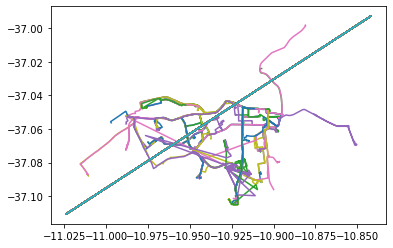

In [ ]:
for i in range(len(data)):
    plt.plot(data[i][:,0], data[i][:,1])
    plt.plot(x, y)
plt.show()

In [ ]:
def queryRankList(query, reduction_dim, option, max_limit, k=None, r=None): 
    '''
    returns a list; the indices of the trajectories to be retrieved for the query
    '''
    mappedReducedQuery = dimReducedQuery(query, option=option)
    distQueryFromReducedData = LA.norm(reducedData - mappedReducedQuery.reshape(reduction_dim,1), 
                                       axis=0) / (n_x_grids * n_y_grids)
    distQueryFromReducedDataSortedIndices = np.argsort(distQueryFromReducedData)
    if k:
        return distQueryFromReducedDataSortedIndices[:k]
    elif r:
        idx = np.where(distQueryFromReducedData < r)[0]
        return idx[:max_limit]
    else:
        print(colored("Please specify k or r", "yellow"))
        return

In [ ]:
def dataRankedLists(data_vectorized, reducedData, option, path=None): 
    # get real dists of data points with grid aggregated distance
    n = len(data)
    distsData = np.zeros((n, n))
    for j in range(n-1):
        distsData[j][j+1:] = gridAggregateDistVectorized(data_vectorized[j], 
                                                         data_vectorized[j+1:], 
                                                         option=option)
    distsData = distsData + distsData.T
    distsDataArgSorts = np.argsort(distsData)
    if path:
        np.savetxt(path+"distsData_"+option+".csv", distsData, delimiter=",")
        np.savetxt(path+"distsDataArgSorts_"+option+".csv", distsDataArgSorts, delimiter=",")

    # get dists of data points after dim reduction
    distsReducedData = np.zeros((n,n))
    for j in range(n-1):
        a = LA.norm(reducedData[j] - reducedData[j+1:], axis=1)/(n_x_grids * n_y_grids)
        distsReducedData[j][j+1:] = a
    distsReducedData = distsReducedData + distsReducedData.T
    distsReducedDataArgSorts = np.argsort(distsReducedData)
    if path:
        np.savetxt(path+"distsReducedData_"+option+".csv", distsReducedData, delimiter=",")
        np.savetxt(path+"distsReducedDataArgSorts_"+option+".csv", distsReducedDataArgSorts, delimiter=",")
    return distsData, distsDataArgSorts, distsReducedData, distsReducedDataArgSorts


In [ ]:
start_time = time.time()
print("option:", option)
distsData, distsDataArgSorts, distsReducedData, distsReducedDataArgSorts = \
                            dataRankedLists(D_tilda.T, reducedData.T, option, path)
print(time.time() - start_time)

option: binary
103.48799228668213


In [ ]:
sum(np.argsort(distsData[0]) != np.argsort(distsReducedData[0]))

64

In [ ]:
data_ranked_list_dtw = np.argsort(dists_dtw)
data_ranked_list_dtw.shape

(105, 105)

In [ ]:
def precisionAndRecallData(data, N, max_limit, distsData, distsDataArgSorts, 
                           distsReducedData, distsReducedDataArgSorts, k=None, r=None): 
    '''
    calculates percision and recall for all data points as well as 
    the average of percision and recall for all data @N (Note: This is not AP)
    This function is not sensitive to k if k>=N.
    Note: Don't give values for both k and r (one of them should be None).
    '''
    percision = np.zeros(len(data))
    recall = np.zeros(len(data))
    if (k and r):
        for j in range(len(data)):
            c = 0
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j][:N]:
                    c += 1
            percision[j] = c/N
            recall[j] = c/N
        percision_k = percision.copy()
        recall_k = recall.copy()
        for j in range(len(data)):
            d = 0
            idx = np.where(distsData[j] < r)[0][:min(max_limit, N)]
            idx_red = np.where(distsReducedData[j] < r)[0][:min(max_limit, N)]
            for i in range(len(idx_red)):
                if idx_red[i] in idx:
                    d += 1
            percision[j] = d/len(idx_red)
            recall[j] = d/len(idx)
        return {f"k={k}:": [percision_k, recall_k, np.mean(percision_k), np.mean(recall_k)],
                f"r={r}:": [percision, recall, np.mean(percision), np.mean(recall)]}
    elif k:
        for j in range(len(data)):
            c = 0
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j][:N]:
                    c += 1
            percision[j] = c/N
            recall[j] = c/N
        return percision, recall, np.mean(percision), np.mean(recall)
    elif r:
        for j in range(len(data)):
            c = 0
            idx = np.where(distsData[j] < r)[0]
            idx_red = np.where(distsReducedData[j] < r)[0]
            I = np.argsort(distsData[j][idx])
            idx = idx[I][:min(max_limit, N)]
            J = np.argsort(distsReducedData[j][idx_red])
            idx_red = idx_red[J][:min(max_limit, N)]
            for i in range(len(idx_red)):
                if idx_red[i] in idx:
                    c += 1
            percision[j] = c/len(idx_red)
            recall[j] = c/len(idx)
        return percision, recall, np.mean(percision), np.mean(recall)
    else:
        print(colored("Pleas specify the value of k or r.", "yellow"))

### Average of percisions of all data points where each is used as kNN queries

With GAD as ground truth

In [ ]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50, 
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.87809524 0.91428571 0.95761905]
mean_recall: [0.87809524 0.91428571 0.95761905]


In [ ]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50, 
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [0.93142857 0.93428571 0.97      ]
mean_recall: [0.93142857 0.93428571 0.97      ]


With dtw as ground truth

In [ ]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50,
                            distsData=dists_dtw, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.56       0.53809524 0.50904762]
mean_recall: [0.56       0.53809524 0.50904762]


In [ ]:
# Note: for kNN queries percision and recall are the same
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for k in [5, 10, 20]:
    a, b, c, d = precisionAndRecallData(data, N=k, max_limit=50, 
                            distsData=dists_dtw, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=k, r=None)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [0.54285714 0.53333333 0.52809524]
mean_recall: [0.54285714 0.53333333 0.52809524]


### Averages of percisions and recalls of all data points where each is used as range queries

In [ ]:
np.max(distsData), np.max(distsReducedData)

(0.01428876932754324, 0.014246646851589056)

With GAD as ground truth

In [ ]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50,  
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.86344293 0.87754346 0.91714286]
mean_recall: [0.96571429 0.91619048 0.91714286]


In [ ]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50, 
                            distsData=distsData, distsDataArgSorts=distsDataArgSorts, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [0.99142857 0.96031746 0.90564626]
mean_recall: [1.         1.         0.99904762]


 With dtw as ground truth

In [ ]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50,  
                            distsData=dists_dtw/10, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: binary
mean_percision: [0.57516629 0.36469388 0.37047619]
mean_recall: [0.9952381  0.95142857 0.87625472]


In [ ]:
print("option:", option)
percision = []
recall = []
mean_percision = []
mean_recall = []

for r in [0.002, 0.005, 0.01]:
    a, b, c, d = precisionAndRecallData(data, N=10, max_limit=50, 
                            distsData=dists_dtw/10, distsDataArgSorts=data_ranked_list_dtw, 
                            distsReducedData=distsReducedData, 
                            distsReducedDataArgSorts=distsReducedDataArgSorts, k=None, r=r)
    percision.append(a)
    recall.append(b)
    mean_percision.append(c)
    mean_recall.append(d)

print(colored(f"mean_percision: {np.array(mean_percision)}", 'yellow'))
print("mean_recall:", np.array(mean_recall))

option: multipass
mean_percision: [1.         0.98571429 0.86869992]
mean_recall: [0.76428571 0.63738095 0.54518519]


## AP and MAP

In [ ]:
def precisionAndRecallDataPoint(index, N, max_limit, distsData, distsDataArgSorts, 
                                distsReducedData, distsReducedDataArgSorts, k=None, r=None): 
    '''
    calculates percision and recall for one data point (as a query) @ N
    index: the index of data point
    path='/content/gdrive/My Drive/IR Project/Car-Bus/'
    This function is not sensitive to k if k >= N
    '''
    if k:
        c = 0
        for i in range(N):
            if distsReducedDataArgSorts[index][i] in distsDataArgSorts[index][:N]:
                c += 1
        percision = c/N
        recall = c/N
        return percision, recall
    elif r:
        c = 0
        idx = np.where(distsData[index] < r)[0]
        idx_red = np.where(distsReducedData[index] < r)[0]
        I = np.argsort(distsData[index][idx])
        idx = idx[I][:min(max_limit, N)]
        J = np.argsort(distsReducedData[index][idx_red])
        idx_red = idx_red[J][:min(max_limit, N)]
        for i in range(len(idx_red)):
            if idx_red[i] in idx:
                c += 1
        percision = c/len(idx_red)
        recall = c/len(idx)
        return percision, recall
    else:
        print(colored("Pleas specify the value of k or r.", "yellow"))

In [ ]:
def averagePrecisionData(data, path, max_limit, reduction_dim, reducedData,  
                         option, k=None, r=None, dtw=False):
    '''
    calculates average percision (AP) for all data points as well as 
    the average of AP on all data points as queries (i.e. MAP)
    path='/content/gdrive/My Drive/IR Project/Car-Bus/'
    Note: Don't give values for both k and r (one of them should be None).
    '''
    if dtw:
        distsData = dists_dtw/10
        distsDataArgSorts = data_ranked_list_dtw
    else:
        distsData = np.array(pd.read_csv(path+"distsData_"+option+".csv", header=None))
        distsDataArgSorts = np.array(pd.read_csv(path+"distsDataArgSorts_"+option+".csv", header=None))
    
    distsReducedData = np.array(pd.read_csv(path+"distsReducedData_"+option+".csv", header=None))
    distsReducedDataArgSorts = np.array(pd.read_csv(path+"distsReducedDataArgSorts_"+option+".csv", header=None))
    n = len(data)
    AP = np.zeros(n)
    if k:
        AP_temp = np.zeros((k, n))
        for i in range(k):
            percision, _, _, _ = precisionAndRecallData(data, i+1, max_limit,  
                                    distsData, distsDataArgSorts, distsReducedData, 
                                    distsReducedDataArgSorts, k=k, r=r)
            for t in range(n):
                if distsReducedDataArgSorts[t][i] in distsDataArgSorts[t]:
                    AP_temp[i][t] = percision[t] 

        AP = np.mean(AP_temp, 0)
        MAP = np.mean(AP)
        return AP, MAP
    elif r:
        for t in range(n):
            AP_temp = []
            s = len(queryRankList(data[t], reduction_dim, option, max_limit, k=None, r=r))
            for i in range(s):
                percision, _ = precisionAndRecallDataPoint(t, i+1, max_limit,  
                                distsData, distsDataArgSorts, distsReducedData, 
                                    distsReducedDataArgSorts, k=None, r=r)
                idx = np.where(distsData[t] < r)[0]
                idx_red = np.where(distsReducedData[t] < r)[0]
                I = np.argsort(distsData[t][idx])
                idx = idx[I][:min(max_limit, i+1)]
                J = np.argsort(distsReducedData[t][idx_red])
                idx_red = idx_red[J][:min(max_limit, i+1)]
                if i < len(idx_red):
                    if idx_red[i] in idx:
                        AP_temp.append(percision)
            AP[t] = np.sum(AP_temp)/s
        MAP = np.mean(AP)
        return AP, MAP

### AP and MAP for kNN queries

#### binary

In [ ]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []
path = '/content/gdrive/My Drive/IR Project/Car-Bus/'

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=False)
    AP.append(a)
    MAP.append(b)

print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: binary
MAP: [0.89292063 0.89955367 0.92400032]
Total time: 0.34138035774230957


with dtw

In [ ]:
print("option:", option)
start_time = time.time()
AP = []
MAP = []

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=True)
    AP.append(a)
    MAP.append(b)

print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: binary
MAP: [0.65803175 0.6022585  0.55688166]
Total time: 0.3364250659942627


#### Multipass

In [ ]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=False)
    AP.append(a)
    MAP.append(b)

print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: multipass
MAP: [0.95787302 0.94957974 0.95298007]
Total time: 0.34154462814331055


with dtw

In [ ]:
print("option:", option)
start_time = time.time()
AP = []
MAP = []

for k in [5, 10, 20]:
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=k, r=None, dtw=True)
    AP.append(a)
    MAP.append(b)

print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print("Total time:", time.time() - start_time)

option: multipass
MAP: [0.66460317 0.59773621 0.56226299]
Total time: 0.3031306266784668


### AP and MAP for range queries

#### binary

In [ ]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=False)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: binary
time for 0.002: 101.30378484725952
time for 0.005: 102.26783227920532
time for 0.01: 102.7100875377655
MAP: [0.80612116 0.7228063  0.72737918]
306.2884039878845


with dtw

In [ ]:
np.max(dists_dtw)/10

0.17211629604418585

In [ ]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=True)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: binary
time for 0.002: 101.32318472862244
time for 0.005: 101.62988615036011
time for 0.01: 101.82222056388855
MAP: [0.49609288 0.16235595 0.06341763]
304.779910326004


#### Multipass

In [ ]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=False)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: multipass
time for 0.002: 101.0801637172699
time for 0.005: 100.64984893798828
time for 0.01: 100.59296822547913
MAP: [0.99142857 0.96031746 0.89141311]
302.3275215625763


with dtw

In [ ]:
start_time = time.time()
print("option:", option)
AP = []
MAP = []

for r in [0.002, 0.005, 0.01]:
    s = time.time()
    a, b = averagePrecisionData(data, path, max_limit, reduction_dim, 
                                reducedData, option, k=None, r=r, dtw=True)
    AP.append(a)
    MAP.append(b)
    print(f"time for {r}: {time.time() - s}")
    
print(colored(f"MAP: {np.array(MAP)}", 'yellow'))
print(time.time() - start_time)

option: multipass
time for 0.002: 100.52183413505554
time for 0.005: 100.72295641899109
time for 0.01: 101.19451594352722
MAP: [0.98169841 0.95239153 0.77363392]
302.4450349807739


## nDCG

In [ ]:
def nDCG(data, path, max_limit, reduction_dim, option, N, k=None, r=None, dtw=False):
    '''
    calculates average nDCG @N for all data points as well as 
    the average of nDCG @N on all data points as queries;
    N should be <= k;
    path='/content/gdrive/My Drive/IR Project/Car-Bus/'
    Note: Don't give values for both k and r (one of them should be None).
    '''
    if dtw:
        distsData = dists_dtw/10
        distsDataArgSorts = data_ranked_list_dtw
    else:
        distsData = np.array(pd.read_csv(path+"distsData_"+option+".csv", header=None))
        distsDataArgSorts = np.array(pd.read_csv(path+"distsDataArgSorts_"+option+".csv", header=None))
        
    distsReducedData = np.array(pd.read_csv(path+"distsReducedData_"+option+".csv", header=None))
    distsReducedDataArgSorts = np.array(pd.read_csv(path+"distsReducedDataArgSorts_"+option+".csv", header=None))
    DCG = np.zeros(len(data))
    if k: 
        iDCG = np.sum([(k-i)/math.log(i+2, 2) for i in range(k)])
        for j in range(len(data)):
            rel = np.zeros(N)
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsDataArgSorts[j]:
                    if k - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i]) > 0:
                        rel[i] = k - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i])
            DCG[j] = np.sum([rel[i]/math.log(i+2, 2) for i in range(N)])
        return DCG/iDCG, np.mean(DCG/iDCG)
    elif r:
        relevance = list(reversed(range(1, N+1)))
        iDCG = np.sum([relevance[i]/math.log(i+2, 2) for i in range(N)])
        for j in range(len(data)):
            I = np.where(distsData[j] < r)[0]
            relevant = distsDataArgSorts[j][:len(I)]
            J = np.where(distsReducedData[j] < r)[0]
            retrieved = distsReducedDataArgSorts[j][:len(J)]
            rel = np.zeros(N)
            for i in range(N):
                if distsReducedDataArgSorts[j][i] in distsReducedDataArgSorts[j][:len(I)]:
                    if N - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i]) > 0:
                        rel[i] = N - distsDataArgSorts[j].tolist().index(distsReducedDataArgSorts[j][i])
            DCG[j] = np.sum([rel[i]/math.log(i+2, 2) for i in range(N)])
        return DCG/iDCG, np.mean(DCG/iDCG)

### nDCG for binary

In [ ]:
# N <= k
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs: [0.93999555 0.79020355 0.59074107]
nDCGs: [0.96459956 0.95878266 0.82099129]


with dtw

In [ ]:
# N <= k
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs: [0.73911551 0.59913406 0.45134234]
nDCGs: [0.80883322 0.71703946 0.58618933]


In [ ]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs@5: [0.74906277 0.89554195 0.93999555]
nDCGs@10: [0.63125019 0.88954515 0.95878266]


with dtw

In [ ]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: binary
nDCGs@5: [0.59572162 0.65426992 0.69134012]
nDCGs@10: [0.45504448 0.53047428 0.5860093 ]


### nDCG for multipass

In [ ]:
# N <= k
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=False)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs: [0.98087892 0.82095106 0.60239576]
nDCGs: [0.9941699  0.98562477 0.82980385]


with dtw

In [ ]:
# N <= k *
print("option:", option)
nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for k in [5, 10, 20]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=k, 
                      r=None, dtw=True)[1])
print(colored(f'nDCGs: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs: [0.73093142 0.5974528  0.46068081]
nDCGs: [0.79638853 0.70525119 0.5880617 ]


In [ ]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=False)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs@5: [0.51753121 0.53928247 0.62596538]
nDCGs@10: [0.35992109 0.37922571 0.47370696]


with dtw

In [ ]:
print("option:", option)
nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=5, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@5: {np.array(nDCGs)}', 'yellow'))

nDCGs = []
for r in [0.002, 0.005, 0.01]:
    nDCGs.append(nDCG(data, path, max_limit, reduction_dim, option, N=10, k=None,
                      r=r, dtw=True)[1])
print(colored(f'nDCGs@10: {np.array(nDCGs)}', 'yellow'))

option: multipass
nDCGs@5: [0.5931745  0.64160653 0.67822177]
nDCGs@10: [0.43632625 0.50724123 0.56315435]
